In [1]:
%load_ext autoreload
%autoreload 2
from pangolin import *
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
np.set_printoptions(precision=2)

based loosely on [this example](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html) from the skikitlearn documentation



In [47]:
# generate training data
ndata = 20
σ = 1.5
x_obs = np.random.rand(ndata)*10
y_obs = x_obs * np.sin(x_obs) + σ * np.random.randn(ndata)

In [51]:
# combine training and "test" data
x_test = np.arange(0,10,.1)
x = np.concatenate([x_obs,x_test])

# kernel function
def kernel(x):
    N = len(x)
    K = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            K[i,j] = np.exp(-1*(x[i]-x[j])**2)
    # make PSD
    return .5*(K+K.T) + .1*np.eye(N)

# compute kernel
K = kernel(x)

# define model
z = multi_normal_cov(np.zeros(len(x)),K)
y_train = vmap(normal,(0,None))(z[:ndata],σ)
y_test = vmap(normal,(0,None))(z[ndata:],σ)

# do inference
calc = Calculate("numpyro",niter=1000)
ys = calc.sample(y_test,y_train,y_obs)

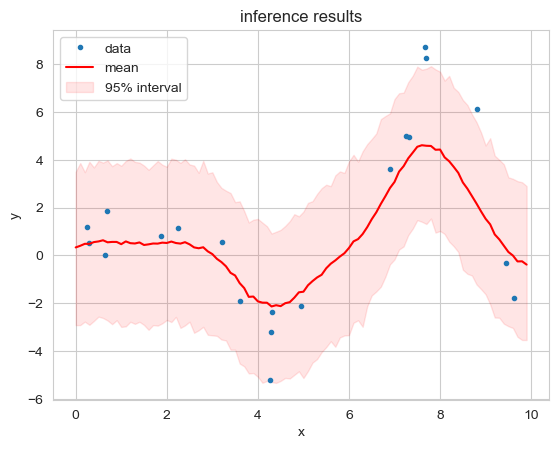

In [52]:
# plot
y_pred = np.mean(ys,axis=0)
y_lo = np.quantile(ys,.025,axis=0)
y_hi = np.quantile(ys,.975,axis=0)

plt.plot(x_obs,y_obs,'.',label='data')
plt.plot(x_test,y_pred,'r-',label='mean')
plt.fill_between(x_test,y_lo,y_hi,color='red',alpha=0.1,label='95% interval')
plt.xlabel('x')
plt.ylabel('y')
plt.title('inference results')
plt.legend();